In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

## Neural Network With NAICS Random Hierarchy , Intermediate Embedding Layer
Use the custom data generator to inject unseen codes into the data during training (with shuffle).  Add a layer in the network to combine all NAICS-hierarchy inputs.  Use a random hierarchy

Similar to "41" in the parent folder, but add an additional layer in the neural network

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed_nomiss.parquet'))

##### Random hieararchy


In [7]:
naics_rand_map = pd.read_parquet(Path(setup.parent_path).joinpath('41_DATA_naics_groups.parquet'))

In [8]:
rgrp_cols = [c for c in naics_rand_map.columns if c != 'NAICS_orig']
rgrp_cols

['rgrp_345', 'rgrp_106', 'rgrp_020']

In [9]:
sba_loans = sba_loans.drop(columns=rgrp_cols, errors='ignore') \
    .merge(naics_rand_map, how='left', on='NAICS_orig')

In [10]:
with open(Path(setup.parent_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
with open(Path(setup.parent_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

In [12]:
rgrp_max_levels = {c:int(c.split('_')[1]) for c in rgrp_cols}
rgrp_max_levels = {**{'NAICS':naics_max_levels['NAICS']}, **rgrp_max_levels}
rgrp_max_levels

{'NAICS': 1170, 'rgrp_345': 345, 'rgrp_106': 106, 'rgrp_020': 20}

In [13]:
size_dict = dict(zip(rgrp_max_levels.keys(),
                     setup.nn_naics_embed_size_dict.values()))
size_dict

{'NAICS': 8, 'rgrp_345': 8, 'rgrp_106': 4, 'rgrp_020': 4}

##### Features

In [14]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [15]:
# NAICS features - random groups
features_naics = ['NAICS'] + rgrp_cols
features_naics_max_levels  = [rgrp_max_levels[n] for n in features_naics]
features_naics_emb_dim = [size_dict[n] for n in features_naics]

In [16]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 106, 20]
[8, 8, 4, 4]


##### Datasets for train, validation

In [17]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [18]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [19]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


In [20]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

In [21]:
importlib.reload(sbnn_model)

<module 'sba_nn.sba_nn.sbnn_model' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_model.py'>

In [22]:
this_model = \
    sbnn_model.create_emb_model_intermediate(features_numeric_len,
                                            features_naics_max_levels,
                                            features_naics_emb_dim,
                                            naics_embedding_names = features_naics,
                                            hidden_size = setup.nn_layer_sizes,
                                            activation='tanh',
                                            lr=setup.nn_learning_rate,
                                            opt_func = setup.nn_optimizer,
                                            dropout = setup.nn_dropout)

2024-07-13 06:44:21.770207: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-13 06:44:21.770232: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-13 06:44:21.770238: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-13 06:44:21.770276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-13 06:44:21.770298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

##### Use data generator to inject 1 values into training data

In [24]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0.1,
                               injection_value = 1)

In [25]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [26]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                              callbacks=[callback])

Epoch 1/20


2024-07-13 06:44:22.767224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4645 - auc: 0.3322 - auc_1: 0.6952

2024-07-13 06:47:09.212816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 182s 13ms/step - loss: 0.4645 - auc: 0.3322 - auc_1: 0.6952 - val_loss: 0.4560 - val_auc: 0.3702 - val_auc_1: 0.7229
Epoch 2/20
13964/13964 [==============================] - 175s 13ms/step - loss: 0.4561 - auc: 0.3539 - auc_1: 0.7132 - val_loss: 0.4521 - val_auc: 0.3745 - val_auc_1: 0.7269
Epoch 3/20
13964/13964 [==============================] - 168s 12ms/step - loss: 0.4543 - auc: 0.3600 - auc_1: 0.7171 - val_loss: 0.4520 - val_auc: 0.3757 - val_auc_1: 0.7261
Epoch 4/20
13964/13964 [==============================] - 166s 12ms/step - loss: 0.4534 - auc: 0.3637 - auc_1: 0.7191 - val_loss: 0.4506 - val_auc: 0.3813 - val_auc_1: 0.7291
Epoch 5/20
13964/13964 [==============================] - 166s 12ms/step - loss: 0.4526 - auc: 0.3648 - auc_1: 0.7206 - val_loss: 0.4504 - val_auc: 0.3833 - val_auc_1: 0.7303
Epoch 6/20
13964/13964 [==============================] - 210s 15ms/step - loss: 0.4521 - auc: 0.3669 - auc_1: 0.7218 - val_loss: 0.4509

In [27]:
this_history_df = sbnn_model.process_history(this_history)

In [28]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('A03_REPORT_fit_history.csv'))

<Axes: >

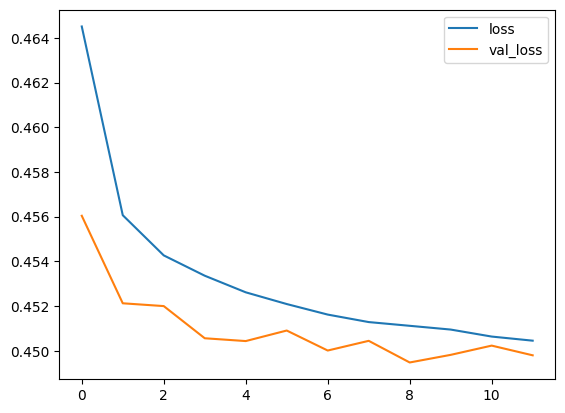

In [29]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

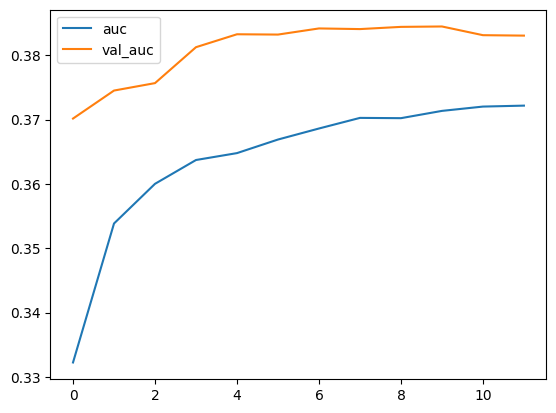

In [30]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

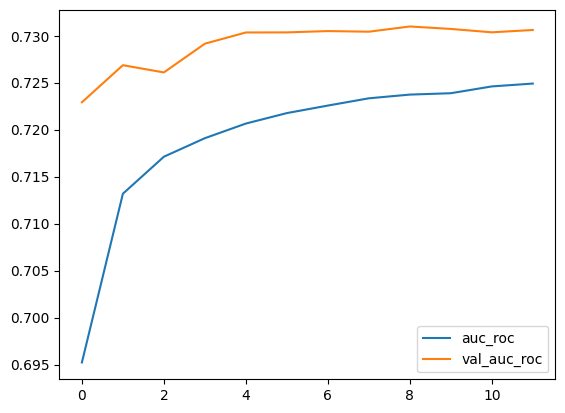

In [31]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [32]:
this_model.save(Path(setup.temp_path).joinpath('A03_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [33]:
all_predictions = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])

   85/21735 [..............................] - ETA: 38s

2024-07-13 07:21:50.128435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 51s 2ms/step


In [34]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [35]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.318157
target,0.318157,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [36]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [37]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [38]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.452025
12,0.24,0.451335
10,0.20,0.449986


In [39]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [40]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [41]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.563639
1    0.436361
Name: proportion, dtype: float64

In [42]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('A03_DATA_predictions.parquet'))

## Metrics

In [43]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A03_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.643471,0.436569,0.320429,0.684763,0.360862,0.716394,NaN
1,train,0.649234,0.452025,0.330450,0.715122,0.384109,0.732224,NaN
2,val,0.649021,0.453226,0.332052,0.713655,0.383240,0.730668,NaN
0,test,0.646672,0.448110,0.328217,0.706001,0.377234,0.725877,0.0
1,test,0.638152,0.416776,0.306997,0.648774,0.326655,0.699616,1.0
